**Import Packages and Libraries**

In [8]:
import os
import copy 
import wandb
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score

import torch
import torch.nn.functional as F 
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.optim as optim
import torchinfo 

import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")

from custom_data import CustomDataset
from utils import EarlyStopping
from create_model import get_model_optimizer

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [20]:
early_stopping = EarlyStopping(patience=5, min_delta=0.0001, restore_best_weights=True)

In [3]:
data_dir = '../data_dir/car_images'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'valid')
print(train_dir) 
print(validation_dir)

../data_dir/car_images/train
../data_dir/car_images/valid


#### **Image Transformation and  Augmentation**

In [4]:
# Define dataset transforms 
def get_transforms():
    """
    
    """
    minority_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomRotate90(p=0.3),
        A.OpticalDistortion(always_apply=False, p=0.4, distort_limit=(-0.23, 0.09), shift_limit=(-0.13, 0.22), interpolation=1),
        A.CLAHE(always_apply=False, p=0.3, clip_limit=(1, 11), tile_grid_size=(5, 5)),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.4),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.Resize(height=224, width=224, interpolation=cv2.INTER_AREA), 
        ToTensorV2()
    ])
    majority_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.Resize(height=224, width=224, interpolation=cv2.INTER_AREA), 
        ToTensorV2()
    ])

    test_transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.Resize(height=224, width=224, interpolation=cv2.INTER_AREA),
        ToTensorV2()
        
    ])

    return minority_transform, majority_transform, test_transform

In [15]:
def get_dataloaders(sampling = False,
                    root_dir:str = data_dir,
                    ):
    """
    
    """
    minority_transform, majority_transform, test_transform = get_transforms()
    train_dataset = CustomDataset(data_dir=root_dir, mode='train', transform={'minority': minority_transform, 'majority': majority_transform})
    valid_dataset = CustomDataset(data_dir=root_dir, mode='valid', transform=test_transform)
    

    if sampling : 
        # Create WeightedRandomSampler for training dataset
        weights_train = [train_dataset.class_weights[label] for label in train_dataset.labels]
        sampler_train = WeightedRandomSampler(weights_train, len(weights_train), replacement=False) ##TODO : Adjust replacement True/False as per need 
        train_loader = DataLoader(train_dataset, batch_size=16, sampler= sampler_train, num_workers=8, pin_memory=True)
        validation_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers= 8, pin_memory=True)
    else: 
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)
        validation_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)

    return train_loader, validation_loader

#### **Class Distribution Per Branch (Before Sampling)**

In [7]:
train_loader, val_loader = get_dataloaders()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


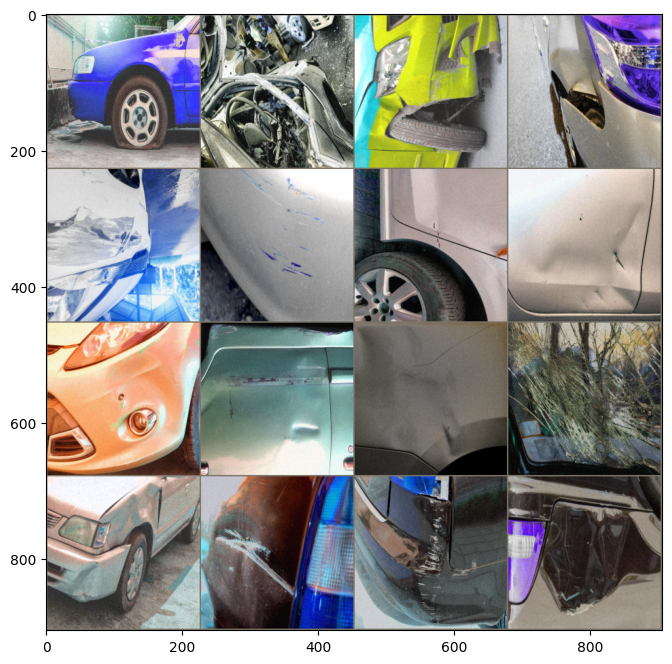

In [10]:
from torchvision.utils import make_grid
for images,labels, _ in train_loader: 
    break

# Print the labels
print('Labels:', labels.numpy())

im = make_grid(images['image'], nrow=4)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(16,8))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

We can notice huge class imbalance in first  batch. !! 

#### **Class Distribution Per Branch (After Sampling)**

In [16]:
train_loader, val_loader = get_dataloaders(sampling=True) # apply WeightedRandomSampling  to handle class Imbalance 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: [0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0]


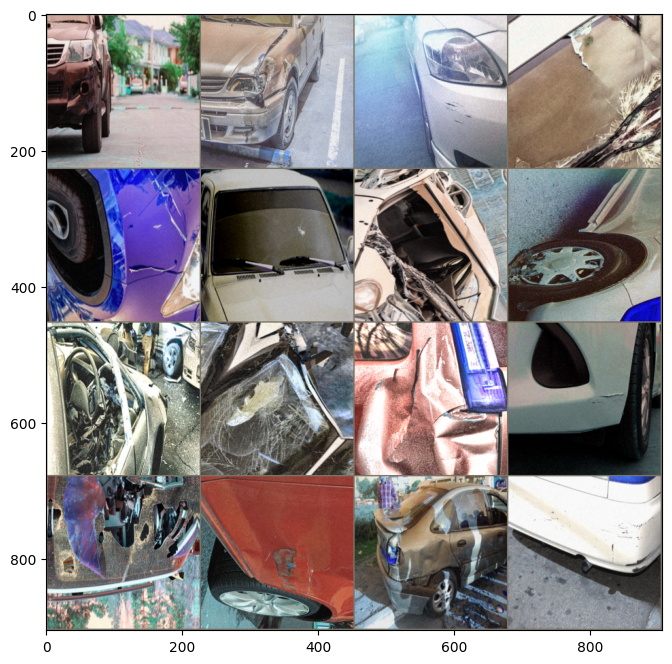

In [17]:
from torchvision.utils import make_grid
for images,labels, _ in train_loader: 
    break

# Print the labels
print('Labels:', labels.numpy())

im = make_grid(images['image'], nrow=4)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(16,8))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

we can see lot more samples from minority class.

### **TRAINING LOOP**

In [24]:
def training_model(model,dataloader,
                    optimizer, 
                    loss_fn, 
                    device
                    ):
    
    #wandb.watch(model, loss_fn, log='all', log_freq='50')

    model.train()
    L , acc = 0, 0
    true_labels , predicted_labels = [], [] 
    for i , (images, labels, _) in enumerate(dataloader):

        images = images['image'].to(device)
        labels = labels.to(device)
       
        # Forward Pass
        y_pred = model(images)
        loss = loss_fn(y_pred, labels)
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        #Step with optimizer
        optimizer.step()
        
        L += loss.item()
        acc += (y_pred.argmax(dim=1) == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(y_pred.argmax(dim=1).cpu().numpy())
    
    # Calculate average loss and accuracy
    avg_loss = L / len(dataloader)
    accuracy = acc/ (len(true_labels))
    
    # Calculate precision, recall, and AUC-PR
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    cm = confusion_matrix(true_labels, predicted_labels)
    

    training_results = {
        'Loss' : avg_loss,
        'Accuracy' : accuracy,
        'Precision' : precision,
        'Recall' : recall,
        'F1-Macro' : f1,
        'Confusion Matrix' : cm
    }
    
    
    return training_results

### **VALIDATION LOOP**

In [25]:
def validation_model(model,
                     dataloader,
                     loss_fn, 
                     device,
                     early_stopping = None,
                     ):

    model.eval()
    L , acc = 0, 0
    true_labels , predicted_labels = [], []
    
    with torch.no_grad():
    
        for i , (images, labels) in enumerate(dataloader):
            images = images['image'].to(device)
            labels = labels.to(device)
          
            y_pred = model(images)
            loss = loss_fn(y_pred, labels)
            L += loss.item()
            acc += (y_pred.argmax(dim=1) == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(y_pred.argmax(dim=1).detach().cpu().numpy())

            # # Early stopping check
            if early_stopping and early_stopping(model, loss.item()):
                break  # Early stopping triggered, exit loop
    
    # Calculate average loss and accuracy
    avg_loss = L / len(dataloader)
    accuracy = acc/ (len(true_labels))
    
    # Calculate precision, recall, and AUC-PR
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Early stopping check based on F1-score
    if early_stopping and early_stopping(model, f1):
        print("Early stopping triggered.")
        model.train()
        return None  # Indicate early stopping


    validation_results = {
        'Loss' : avg_loss,
        'Accuracy' : accuracy,
        'Precision' : precision,
        'Recall' : recall,
        'F1-Macro' : f1,
        'Confusion Matrix' : cm
    }
     # Early stopping check based on F1-score
    if early_stopping and early_stopping(model, f1):
        print("Early stopping triggered.")
        model.train()
        return None  # Indicate early stopping

    model.train()
        
    return validation_results, true_labels, predicted_labels

### **Model Training Pipeline**

In [26]:
def model_pipeline( hyperparams, data_dir=data_dir, device=device):
        wandb.init(project='Insurance_Fraud_V2', name='efnetb0-nosampling_1', config=hyperparams)
        config = wandb.config

        # get  data loaders 
        train_loader, valid_loader = get_dataloaders(config=config, root_dir=data_dir)
        # get model , optimisers and loss function 
        model, optimizer = get_model_optimizer(config=config, device=device)
        model = model.to(device)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in tqdm(range(config.epochs)):

        
            train_res = training_model(model=model, 
                                            dataloader=train_loader,
                                            optimizer=optimizer,
                                            loss_fn=loss_fn,
                                            device=device)
            

            val_res, y_true, y_pred = validation_model(model=model, 
                                       dataloader=valid_loader,
                                       loss_fn=loss_fn,
                                       early_stopping=None,
                                        device=device)
            
            
            wandb.log({'train/loss':train_res['Loss'] ,'train/precsion': train_res['Precision'],
                       'train/recall':train_res['Recall'] ,'train/f1-macro':train_res['F1-Macro'],
                       })
            
            wandb.log({'valid/loss':val_res['Loss'],'valid/precsion': val_res['Precision'],
                       'valid/recall':val_res['Recall'],'valid/f1-macro':val_res['F1-Macro'],
                       'confusion_matrix': wandb.plot.confusion_matrix(y_true=y_true, preds=y_pred,
                                                                       class_names=['non-fraudulent', 'fraudulent'])
                       })

            print("**" * 30)
            print("EPOCH :", epoch+1)
            print('Training Results: ', train_res)
            print('validation_results: ', val_res)
            print("**" * 30)
            
            
        
        wandb.finish()

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Performance Without Handling Class Imbalance 

In [28]:
config = dict(
    epochs = 10,
    classes = 2, 
    batch_size = 16,
    lr = 1e-3,
    architecture = 'EfficientNet_B0',
    num_workers = os.cpu_count(),
    sampling = False
)
wandb.login()
model_pipeline(data_dir=data_dir, device=device, hyperparams=config)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


  0%|          | 0/10 [00:00<?, ?it/s]

************************************************************
EPOCH : 1
Training Results:  {'Loss': 0.16553809855474472, 'Accuracy': 0.9463097632678322, 'Precision': 0.5661375661375662, 'Recall': 0.28763440860215056, 'F1-Macro': 0.6766992971507613, 'Confusion Matrix': array([[6009,   82],
       [ 265,  107]])}
validation_results:  {'Loss': 0.16223980464262538, 'Accuracy': 0.9449257425742574, 'Precision': 0.5434782608695652, 'Recall': 0.26881720430107525, 'F1-Macro': 0.6654687888874158, 'Confusion Matrix': array([[1502,   21],
       [  68,   25]])}
************************************************************
************************************************************
EPOCH : 2
Training Results:  {'Loss': 0.12930281569093172, 'Accuracy': 0.9559028315023983, 'Precision': 0.7004608294930875, 'Recall': 0.40860215053763443, 'F1-Macro': 0.7465138960431119, 'Confusion Matrix': array([[6026,   65],
       [ 220,  152]])}
validation_results:  {'Loss': 0.1613893452847358, 'Accuracy': 0.94183168

train/f1-macro,▁▃▄▆▇▆▇▇██
train/loss,█▆▅▃▃▂▂▂▁▁
train/precsion,▁▄▅▇▇▇▇▇██
train/recall,▁▃▃▅▆▆▆▇▇█
valid/f1-macro,▂▅▅▆▇▆█▁▅▇
valid/loss,██▃▅▂▃▁▄▄▂
valid/precsion,▂▁▇▂▅▇▆▇██
valid/recall,▂▇▄█▇▅█▁▄▆
train/f1-macro,0.90129
train/loss,0.06298
train/precsion,0.87346


### **Performance After Handling Class Imbalance(Weighted Random Sampling)**

In [12]:
config = dict(
    epochs = 10,
    classes = 2, 
    batch_size = 16,
    lr = 1e-3,
    architecture = 'EfficientNet_B0',
    num_workers = os.cpu_count(),
    sampling = True
)
wandb.login()
model_pipeline(data_dir=data_dir, device=device, hyperparams=config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: akshar1895. Use `wandb login --relogin` to force relogin


  0%|          | 0/10 [00:00<?, ?it/s]

************************************************************
EPOCH : 1
Training Results:  {'Loss': 0.2917914262484058, 'Accuracy': 0.8802413739749343, 'Precision': 0.880569306930693, 'Recall': 0.8800247371675943, 'F1-Macro': 0.880241348171287, 'Confusion Matrix': array([[2843,  386],
       [ 388, 2846]])}
validation_results:  {'Loss': 0.1371480336062389, 'Accuracy': 0.9560643564356436, 'Precision': 0.5753424657534246, 'Recall': 0.9032258064516129, 'F1-Macro': 0.8396034261253944, 'Confusion Matrix': array([[1461,   62],
       [   9,   84]])}
************************************************************
************************************************************
EPOCH : 2
Training Results:  {'Loss': 0.18498744975918405, 'Accuracy': 0.926814172984682, 'Precision': 0.9248826291079812, 'Recall': 0.926913425345044, 'F1-Macro': 0.9268029578319052, 'Confusion Matrix': array([[3035,  240],
       [ 233, 2955]])}
validation_results:  {'Loss': 0.11986053611917219, 'Accuracy': 0.9554455445544554

train/f1-macro,▁▄▅▇▇▇████
train/loss,█▅▄▃▂▂▁▁▁▁
train/precsion,▁▄▆▇▇▇████
train/recall,▁▄▅▆▇▇▇███
valid/f1-macro,▁▁▃█▇▆▇▇▇█
valid/loss,█▇▅▂▂▃▁▂▁▁
valid/precsion,▁▁▃██▆▆▇▇█
valid/recall,▂▄▄▄▃▃█▁▇▇
train/f1-macro,0.97958
train/loss,0.06355
train/precsion,0.97846


________________________________